In [103]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

## Applying Bag of Words to a collection of abstracts from ArXiv articles.

In [104]:
df = pd.read_csv("./data/df_experiment")
df.head()

,Unnamed: 0,entry_id,updated,published,title,summary,primary_category,categories,authors
0,0,http://arxiv.org/abs/2305.11154v1,2023.42,2023.42,non linear operator valued elliptic flows with...,differential equations on spaces of operators ...,ph,['mp'],"['jean bernard bru', 'nathan metraud']"
1,1,http://arxiv.org/abs/2305.11103v1,2023.42,2023.42,blockwise inversion and algorithms for inverti...,using the blockwise matrix inversion inversion...,na,"['na', 'na', 'mp']",['r thiru senthil']
2,2,http://arxiv.org/abs/2305.11054v1,2023.42,2023.42,ising systems measures on the sphere and zonoids,we give an interpretation of a class of discre...,ap,"['ap', 'mp', 'oc']","['andrea braides', 'antonin chambolle']"
3,3,http://arxiv.org/abs/2210.09458v2,2023.42,2022.83,mobility edge for levy matrices,levy matrices are symmetric random matrices wh...,pr,"['pr', 'mp']","['amol aggarwal', 'charles bordenave', 'patric..."
4,4,http://arxiv.org/abs/2205.08765v2,2023.42,2022.42,necessary and sufficient conditions for one di...,this paper deals with necessary and sufficient...,ca,"['ca', 'ft', 'mp']",['pavol quittner']


In [105]:
df = df.drop(['Unnamed: 0'], axis=1)

In [106]:
## Tokenize the abstract by splitting on whitespaces
## and get rid of the occasional empty string.
def clear_empty(clean_string):
    return [word for word in clean_string.split(" ") if word != '']

In [107]:
# print(stopwords.words('english'))

In [108]:
## Remove stop words from the tokenized abstracts
def remove_stop(tokens):
    return [token for token in tokens if token not in stopwords.words('english')]

In [109]:
## split the abtracts 
df['summary_tokenized'] = df['summary'].apply(clear_empty)

## remove the stop words from the abstracts
df['summary_tokenized'] = df['summary_tokenized'].apply(remove_stop)
df.head()

,entry_id,updated,published,title,summary,primary_category,categories,authors,summary_tokenized
0,http://arxiv.org/abs/2305.11154v1,2023.42,2023.42,non linear operator valued elliptic flows with...,differential equations on spaces of operators ...,ph,['mp'],"['jean bernard bru', 'nathan metraud']","[differential, equations, spaces, operators, l..."
1,http://arxiv.org/abs/2305.11103v1,2023.42,2023.42,blockwise inversion and algorithms for inverti...,using the blockwise matrix inversion inversion...,na,"['na', 'na', 'mp']",['r thiru senthil'],"[using, blockwise, matrix, inversion, inversio..."
2,http://arxiv.org/abs/2305.11054v1,2023.42,2023.42,ising systems measures on the sphere and zonoids,we give an interpretation of a class of discre...,ap,"['ap', 'mp', 'oc']","['andrea braides', 'antonin chambolle']","[give, interpretation, class, discrete, contin..."
3,http://arxiv.org/abs/2210.09458v2,2023.42,2022.83,mobility edge for levy matrices,levy matrices are symmetric random matrices wh...,pr,"['pr', 'mp']","['amol aggarwal', 'charles bordenave', 'patric...","[levy, matrices, symmetric, random, matrices, ..."
4,http://arxiv.org/abs/2205.08765v2,2023.42,2022.42,necessary and sufficient conditions for one di...,this paper deals with necessary and sufficient...,ca,"['ca', 'ft', 'mp']",['pavol quittner'],"[paper, deals, necessary, sufficient, conditio..."


In [112]:
# This will take in a dataframe of "words" (note ngrams will work as well)
# and return a list of the unique words, which forms the basis set

def get_bow_basis(df,column_name):
    basis_set = []
    
    for i in df.index:
        for word in df[column_name][i]:
            basis_set.append(word)
    ## The set function removes duplicates        
    return np.array(list(set(basis_set)))

## This will take in a basis set and a message's tokens
## and return the bag of words numpy array (vector)
def get_bow_vector(tokens, basis_set):
    vector = np.zeros(len(basis_set))
    
    for word in tokens:
        # Note this is here for when we look at the test set
        if word in basis_set:
            vector[basis_set == word] = vector[basis_set == word] + 1
        
    return vector

In [114]:
basis_set = get_bow_basis(df, 'summary_tokenized')
print("The length of the basis set is", len(basis_set))
#print((basis_set))

# Without removing stopwords the length of the basis set is 16136.

The length of the basis set is 16011


Next, we make the <i>document-term matrix </i> which is an `np.array` that records the bag of words vector for each of the abstracts in the dataframe. Each row of the array represents an abstract and each column reprensents one of the entries of the basis set.

In [115]:
doc_term_matrix = np.zeros((len(df), len(basis_set)))

for i in range(len(df)):
    ## Each row of the array is replaced with the bag of words vector 
    ## for that document (abstract)
    doc_term_matrix[i,:] = get_bow_vector(list(df.summary_tokenized)[i], basis_set)

In [116]:
np.shape(doc_term_matrix)

(4462, 16011)

#### Some PCA analysis

In [117]:
## import pca and matplotlib.pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

In [118]:
# This is a pipeline that scales the data and then
# applies pca
pca_pipe = Pipeline([('scale',StandardScaler()),
                         ('pca',PCA())])

# This fits the pipeline
pca_pipe.fit(doc_term_matrix)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA())])

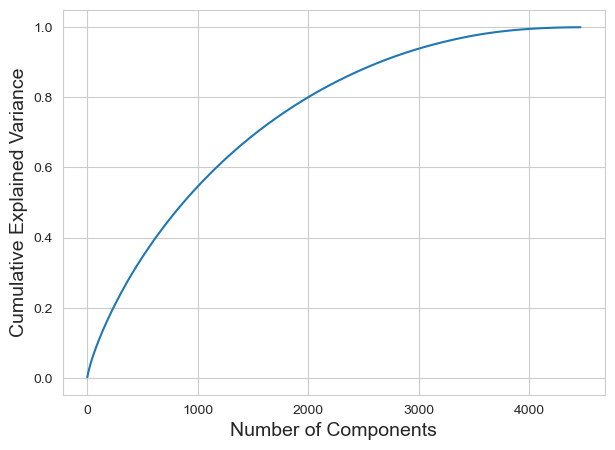

In [119]:
plt.figure(figsize=(7,5))

# plot the number of components on the x
# plot the explained variance ratio on the y
plt.plot(range(1, len(pca_pipe['pca'].explained_variance_ratio_)+1),
            np.cumsum(pca_pipe['pca'].explained_variance_ratio_))

plt.xlabel("Number of Components",fontsize=14)
plt.ylabel("Cumulative Explained Variance",fontsize=14)

plt.show()

### Word Frequency Vectors

In [120]:
## Convert the document-term matrix from a bag of words matrix 
## to a frequency matrix, called `doc_term_freq_matrix`.

# np.sum(array,axis=1) computes a row sum
# This gives the word counts for the documents 
# .reshape(-1,1) turns it into a column vector
doc_term_freq_matrix = doc_term_matrix / np.sum(doc_term_matrix,axis=1).reshape(-1,1)

print(np.sum(doc_term_matrix,axis=1).reshape(-1,1))

[[ 92.]
 [ 41.]
 [ 91.]
 ...
 [ 26.]
 [ 25.]
 [118.]]


In [121]:
np.sum(doc_term_freq_matrix,axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

#### PCA analysis on word frequency vectors

In [122]:
# we make a new pipeline for this second model
pca_pipe_freq = Pipeline([('scale',StandardScaler()),
                             ('pca',PCA())])

pca_pipe_freq.fit(doc_term_freq_matrix)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA())])

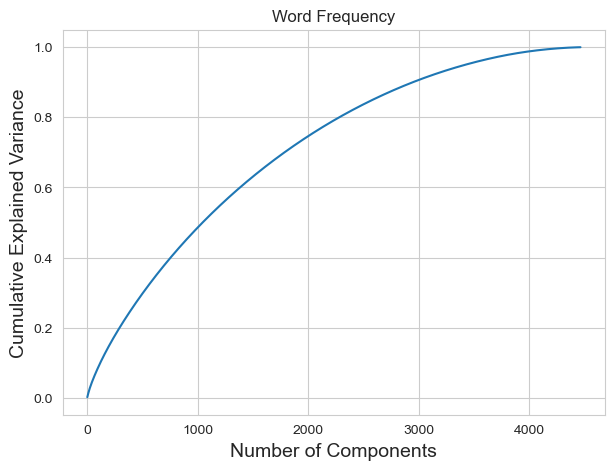

In [130]:
plt.figure(figsize=(7,5))

plt.plot(range(1, len(pca_pipe_freq['pca'].explained_variance_ratio_)+1),
            np.cumsum(pca_pipe_freq['pca'].explained_variance_ratio_))

plt.title("Word Frequency")
plt.xlabel("Number of Components",fontsize=14)
plt.ylabel("Cumulative Explained Variance",fontsize=14)

plt.show()

#### Compute the closeness of  the frequency vectors using cosine similarity

In [38]:
## This code does takes way too long to finish!

# Make a zeros similarity matrix
#word_freq_sim = np.zeros((len(df), len(df)))

#for i in range(len(df)):
#    for j in range(i+1,len(df)):
#       i_j_sim = cos_sim(doc_term_freq_matrix[i,:], doc_term_freq_matrix[j,:])
#        word_freq_sim[i,j] = i_j_sim
#        word_freq_sim[j,i] = i_j_sim
        
#word_freq_sim

In [146]:
#plt.figure(figsize=(14,14))

#plt.imshow(word_freq_sim, cmap='plasma')

#plt.xlabel("ArXiv Document Number", fontsize=18)
#plt.ylabel("ArXiv Document Number", fontsize=18)
#plt.title("Word Frequency Similarity Heat Map", fontsize=18)

#cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 25
#cb.ax.set_ylabel('Cosine Similarity', rotation=270, fontsize=18)

#plt.show()

### TF-IDF Vectors 

Computed as: 
$$
\text{tf-idf } = \text{ term-frequency } \times \text{ }\log(\text{inverse-document-frequency}) \text{}
$$

In [124]:
def get_idf(doc_term_matrix):
    # how many documents are there?
    n_docs = np.shape(doc_term_matrix)[0]
    
    # doc_term_mat>0 makes a boolean array of any time the array >0
    # summing along the columns gives the number of documents each term appears in
    return np.log10(n_docs / np.sum(doc_term_matrix > 0, axis=0))

In [125]:
doc_term_tfidf_matrix = doc_term_freq_matrix * get_idf(doc_term_matrix)

#### PCA analysis on TF-IDF vectors

In [126]:
pca_pipe_tfidf = Pipeline([('scale',StandardScaler()),
                             ('pca',PCA())])

pca_pipe_tfidf.fit(doc_term_tfidf_matrix)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA())])

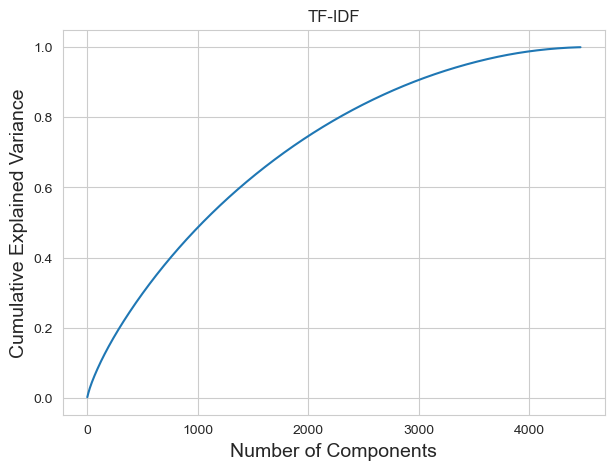

In [129]:
plt.figure(figsize=(7,5))

plt.plot(range(1, len(pca_pipe_tfidf['pca'].explained_variance_ratio_)+1),
            np.cumsum(pca_pipe_tfidf['pca'].explained_variance_ratio_))

plt.title("TF-IDF")
plt.xlabel("Number of Components",fontsize=14)
plt.ylabel("Cumulative Explained Variance",fontsize=14)

plt.show()

#### Calculate the cosine similarity of the TF-IDF vectors

In [144]:
## This takes way to long to run!

## Make a zeros similarity matrix
#word_tfidf_sim = np.zeros((len(df), len(df)))

#for i in range(len(df)):
#    for j in range(i+1,len(df)):
#        i_j_sim = cos_sim(doc_term_tfidf_matrix[i,:], doc_term_tfidf_matrix[j,:])
#        word_tfidf_sim[i,j] = i_j_sim
#        word_tfidf_sim[j,i] = i_j_sim
        
#word_tfidf_sim

In [145]:
#plt.figure(figsize=(14,14))

#plt.imshow(word_tfidf_sim, cmap='plasma')

#plt.xlabel("ArXiv Document Number", fontsize=18)
#plt.ylabel("ArXiv Document Number", fontsize=18)
#plt.title("Word TF-IDF Similarity Heat Map", fontsize=18)

#cb = plt.colorbar()
#cb.ax.get_yaxis().labelpad = 25
#cb.ax.set_ylabel('Cosine Similarity', rotation=270, fontsize=18)

#plt.show()

### Compute the closeness of the articles using cosine similarity

Computing similarity matrices for all of the elements in the database would be very exhaustive, so let's just compare cosine similarity scores for some of the articles in the database to observe differences between word frequency vectors and TF-IDF vectors. 

In [147]:
## A function to get the vector norm
def norm(u):
    return np.sqrt(np.sum(np.power(u,2)))

## A function to get the cosine similarity
def cos_sim(u,v):
    if norm(u)*norm(v) > 0:
        return (u.dot(v))/(norm(u)*norm(v))
    else:
        return np.nan

In [148]:
"""
    Prints the top n most similar article titles from the dataframe
    to the input article by calculating their cosine similarity.
    
    Inputs:
    freq_matrix: a matrix of word frequencies
    article_index: index of the article we want to compare cosine similarities to
    n: the top "n" number of most similar articles to print
"""
def get_most_similar(freq_matrix, article_index , n):
    
    # Calculate the cosine similariy scores for the i-th article in the database
    cosine_sim_list = np.zeros(len(df))

    for i in range(len(df)):
        sim_scores = cos_sim(freq_matrix[article_index,:], freq_matrix[i,:])
        cosine_sim_list[i] = sim_scores
        
    ## Getting indices of n = 10 (+1) maximum values
    ## Note the first value is the similarity value of the 
    ## article to itself
    x = np.argsort(cosine_sim_list)[::-1][:n+1]

    # Remove the first entry in x since it's just
    # the original article itself
    x = np.delete(x,0)
    
    print("The top", n, "articles most similar to the article \n\n", 
            article_index, ".", df['title'][article_index])
    print("-----------------------------------------------------\n")
    
    i = 1
    for index in x: 
        print(i, ".", df['title'][index], 
          ", Cosine Similiarity=", np.round(cosine_sim_list[index], 3))
        print()
        i = i + 1

In [149]:
# The 1st article in the dataframe
article_index = 0

n = 5

print("USING WORD FREQUENCY VECTORS:\n")
get_most_similar(doc_term_freq_matrix, article_index, n)

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("\n USING TF-IDF VECTORS:\n")
get_most_similar(doc_term_tfidf_matrix, article_index, n)

USING WORD FREQUENCY VECTORS:

The top 5 articles most similar to the article 

 0 . non linear operator valued elliptic flows with application to quantum field theory
-----------------------------------------------------

1 . landau ginzburg mirror quantum differential equations and qkz difference equations for a partial flag variety , Cosine Similiarity= 0.358

2 . global dynamics in einstein gauss bonnet scalar field cosmology with matter , Cosine Similiarity= 0.333

3 . galilean fermions classical and quantum aspects , Cosine Similiarity= 0.322

4 . from lindblad master equations to langevin dynamics and back , Cosine Similiarity= 0.319

5 . semisimple dimensional topological field theories cannot detect exotic smooth structure , Cosine Similiarity= 0.308

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

 USING TF-IDF VECTORS:

The top 5 articles most similar to the article 

 0 . non linear operator valued elliptic flows with application to qu

In [155]:
# Another article in the dataframe
article_index = 132

n = 5

print("USING WORD FREQUENCY VECTORS:\n")
get_most_similar(doc_term_freq_matrix, article_index, n)

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("\n USING TF-IDF VECTORS:\n")
get_most_similar(doc_term_tfidf_matrix, article_index, n)

USING WORD FREQUENCY VECTORS:

The top 5 articles most similar to the article 

 132 . quantum operations on conformal nets
-----------------------------------------------------

1 . quantum operations in algebraic qft , Cosine Similiarity= 0.422

2 . compact hypergroups from discrete subfactors , Cosine Similiarity= 0.359

3 . conformal super virasoro algebra matrix model and quantum deformed algebra , Cosine Similiarity= 0.332

4 . finite quantum hypergroups , Cosine Similiarity= 0.315

5 . local energy bounds and strong locality in chiral cft , Cosine Similiarity= 0.304

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

 USING TF-IDF VECTORS:

The top 5 articles most similar to the article 

 132 . quantum operations on conformal nets
-----------------------------------------------------

1 . quantum operations in algebraic qft , Cosine Similiarity= 0.336

2 . compact hypergroups from discrete subfactors , Cosine Similiarity= 0.274

3 . local ene

In [151]:
# Another article in the dataframe
article_index = 3852

n = 5

print("USING WORD FREQUENCY VECTORS:\n")
get_most_similar(doc_term_freq_matrix, article_index, n)

print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

print("\n USING TF-IDF VECTORS:\n")
get_most_similar(doc_term_tfidf_matrix, article_index, n)

USING WORD FREQUENCY VECTORS:

The top 5 articles most similar to the article 

 3852 . kenmotsu manifolds
-----------------------------------------------------

1 . pcr kaehler equivalent metrics in the siegel domain , Cosine Similiarity= 0.389

2 . on estimate for global newlander nirenberg theorem , Cosine Similiarity= 0.326

3 . reconstruction of a lorentzian manifold from its dirichlet to neumann map , Cosine Similiarity= 0.321

4 . cartan connections and path structures with large automorphisms groups , Cosine Similiarity= 0.281

5 . generalized complex structure on certain principal torus bundles , Cosine Similiarity= 0.28

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

 USING TF-IDF VECTORS:

The top 5 articles most similar to the article 

 3852 . kenmotsu manifolds
-----------------------------------------------------

1 . solitonic aspects of submanifolds in kenmotsu statistical manifolds with different vector fields , Cosine Similiari

#### As we can see the ordering and overlap between the cosine similarity results from word frequency vectors and the TF-IDF vectors varies!

### Pending questions

1. How do we use the information from the word-frequency matrices? Perhaps we can explore word frequencies across articles with the same `primary category.`
2. Do we want to use $n$-grams here?